# Model Development

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time

## 1.0 Data
The data being loaded below has already been processed in the data processing notebook of this project.

In [2]:
data = pd.read_csv('input/processed_data_nyc.csv', index_col = 0)
numerical_data = pd.read_csv('input/processed_data_nyc_numerical.csv')
data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,all_year_avail,low_avail,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.010635,1,9,2762,0.21,6,True,False,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,5.420535,1,45,2976,0.38,2,True,False,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,5.017280,3,0,0,0.00,1,True,False,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,4.499810,1,270,3021,4.64,1,False,False,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,4.394449,10,9,2793,0.10,1,False,True,...,0,0,0,0,0,0,0,1,0,0


Since we are predicting price in this notebook, we will take price as the label (y vector) and we will drop it from the features.

In [3]:
y = data.price
data = data.drop(['price'], axis=1)

Now we turn the data and label to numpy arrays, which is more convenient for computations.

In [4]:
X = np.asarray(data)
y = np.asarray(y).ravel()

To test our model, we need to split the data into training and testing sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Dataset: {}".format(X_train.shape))
print("Testing Dataset: {}".format(X_test.shape))

Training Dataset: (39014, 239)
Testing Dataset: (9754, 239)


For better results, data should be scaled to a zero mean and unit variance. This can be done using the robust scaler from scikit-learn.

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 2.0 Models
Before we begin testing different models, we will declare a general function for cross-validation. I will use k-fold validation with 5 folds evaluated based on the mean squared error.

In [7]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_data)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

Now let's do a basic cross-validation test on some well-known regression models without any fine-tuning. We want to get an idea of what's the best model to invest our time in!

In [8]:
MODELS = [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, HuberRegressor]

for Model in MODELS:
    cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 23034350201150.64453 +/- 34661323795323.628906
Ridge: 0.20207 +/- 0.002854
Lasso: 0.45251 +/- 0.005495
ElasticNet: 0.45181 +/- 0.005455
RandomForestRegressor: 0.18457 +/- 0.004537
HuberRegressor: 0.21558 +/- 0.006004


Looking at the above results, the three seemingly best classifiers for this application are:  
1) Random Forest Regressor  
2) Ridge Regressor   
3) Huber Regressor   

As such, I will test these three models and tune their hyperparameters to see which can achieve the best results

### 2.1 Random Forest Regression
In Random Forest Regression, the main parameter to be hypertuned is the number of estimators, which is the number of decision trees used in this ensemble model.

In [9]:
num_estimators = [2, 5, 10, 20, 50, 100, 200, 300]

cv_randomForest = []
cv_randomForest_time = []
counter = 0
for n in num_estimators:
    time1 = time.time()
    cv_temp = -rmse_cv(RandomForestRegressor(n_estimators = n)).mean()
    cv_randomForest.append(cv_temp)
    time2 = time.time()
    timeF = time2- time1
    print("Number of estimators {}: MSE = {}, Time = {}".format(n, cv_randomForest[counter], timeF))
    cv_randomForest_time.append(timeF)
    counter+=1
    

Number of estimators 2: MSE = 0.2679383617126321, Time = 4.203792095184326
Number of estimators 5: MSE = 0.21707664253056502, Time = 9.962335109710693
Number of estimators 10: MSE = 0.19874437601503128, Time = 18.72996187210083
Number of estimators 20: MSE = 0.19089708689790183, Time = 38.436073541641235
Number of estimators 50: MSE = 0.18604605744944308, Time = 97.41615176200867
Number of estimators 100: MSE = 0.18468288062506039, Time = 193.54612922668457
Number of estimators 200: MSE = 0.18376701971862822, Time = 387.2992162704468
Number of estimators 300: MSE = 0.18365731847213862, Time = 578.0025379657745


Now we can plot the cross-validated mean squared error (MSE) for each number of estimators tested.

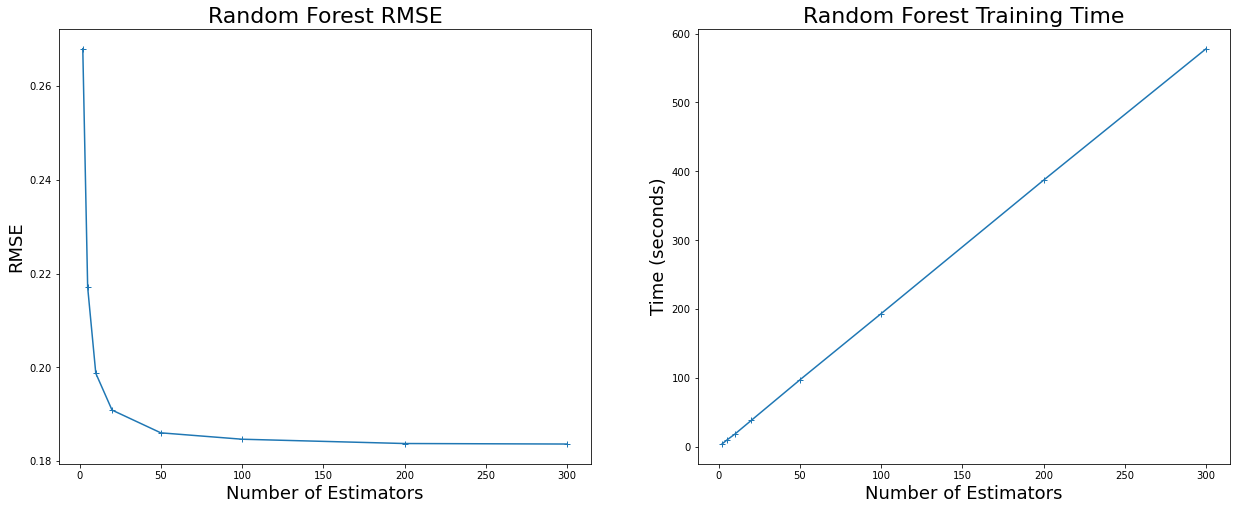

In [10]:
cv_randomForest = pd.Series(cv_randomForest, index = num_estimators)
cv_randomForest_time = pd.Series(cv_randomForest_time, index = num_estimators)

fig, axes = plt.subplots(1,2,figsize=(21, 8))

cv_randomForest.plot(style = '-+', ax = axes[0])
axes[0].set_xlabel("Number of Estimators", fontsize = 18) 
axes[0].set_ylabel("RMSE", fontsize = 18)
axes[0].set_title("Random Forest RMSE", fontsize = 22)

cv_randomForest_time.plot(title = "Random Forest Training Time", style = '-+', ax = axes[1])
axes[1].set_xlabel("Number of Estimators", fontsize = 18) 
axes[1].set_ylabel("Time (seconds)", fontsize = 18)
axes[1].set_title("Random Forest Training Time", fontsize = 22)

plt.savefig('output/figures/random_forest_cv')

Looking at the plot above, we can see that increasing the number of estimators improves the performance of the model. However, this comes at the cost of increased computational burden. Higher number of estimators also means longer training time. So we need to pick a good trade off point where we can achieve computational efficiency. The change in MSE between 50 and 300 is very minor but the change in computational burden (measured through training time) is quite large. For that reason, the number of estimators chosen will be 50.

### 2.2 Ridge Regression
Ridge regression has two main parameters to tune. The first is the solver used to train the regression model, and the regularization strength, alpha, which reduces the variance of the estimates. In the scikit-learn library we are using, the solver is set to auto by default. This means that the algorithm will choose the solver based on the nature of the data automatically. As such, we will only cross validate for alpha values.

In [12]:
alphas = [0.001, 0.01, 0.1, 0.3, 0.5, 1, 1.5, 2, 5, 10, 20, 50, 100]

cv_ridge = []
cv_ridge_time = []
counter = 0
for a in alphas:
    time1 = time.time()
    cv_temp = -rmse_cv(Ridge(alpha = a)).mean()
    cv_ridge.append(cv_temp)
    time2 = time.time()
    timeF = time2- time1
    print("Alpha {}: MSE = {}, Time = {}".format(a, cv_ridge[counter], timeF))
    cv_ridge_time.append(timeF)
    counter+=1

Alpha 0.001: MSE = 0.20246077109469116, Time = 0.5225708484649658
Alpha 0.01: MSE = 0.20245245495083042, Time = 0.5764575004577637
Alpha 0.1: MSE = 0.20237898115446934, Time = 0.5834403038024902
Alpha 0.3: MSE = 0.2022616419475848, Time = 0.5984327793121338
Alpha 0.5: MSE = 0.20218361529242596, Time = 0.5923805236816406
Alpha 1: MSE = 0.2020733553548142, Time = 0.5634951591491699
Alpha 1.5: MSE = 0.2020198240195617, Time = 2.6539194583892822
Alpha 2: MSE = 0.2019918873886019, Time = 1.6008989810943604
Alpha 5: MSE = 0.20198187747143231, Time = 1.096069097518921
Alpha 10: MSE = 0.2020777522898863, Time = 1.1987955570220947
Alpha 20: MSE = 0.20231882524048492, Time = 1.0761613845825195
Alpha 50: MSE = 0.20311403680768403, Time = 1.1957676410675049
Alpha 100: MSE = 0.20441859392779552, Time = 1.056173324584961


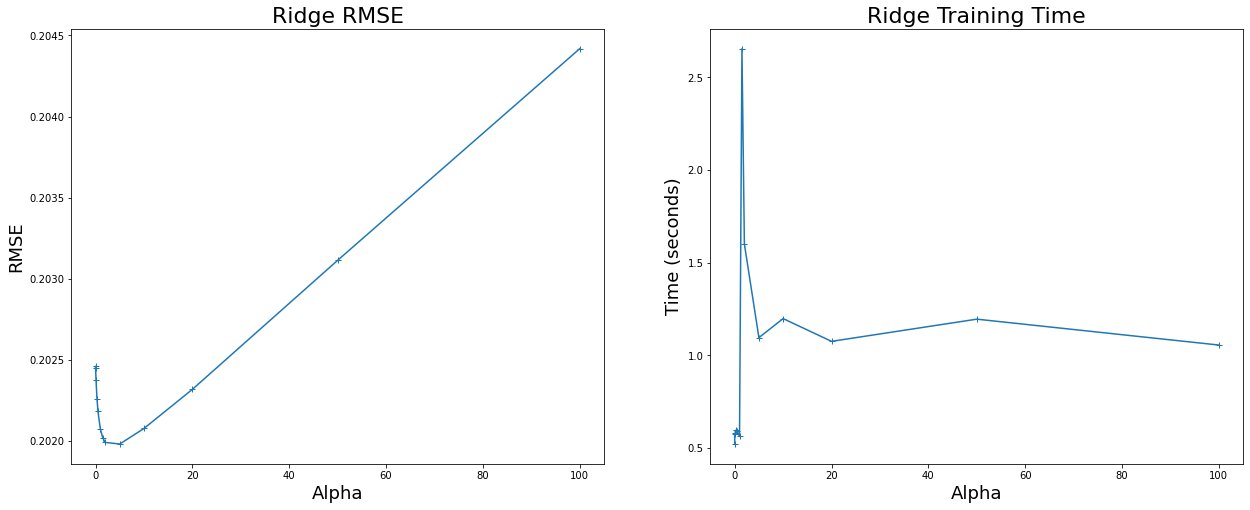

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge_time = pd.Series(cv_ridge_time, index = alphas)

fig, axes = plt.subplots(1,2,figsize=(21, 8))

cv_ridge.plot(style = '-+', ax = axes[0])
axes[0].set_xlabel("Alpha", fontsize = 18) 
axes[0].set_ylabel("RMSE", fontsize = 18)
axes[0].set_title("Ridge RMSE", fontsize = 22)

cv_ridge_time.plot(style = '-+', ax = axes[1])
axes[1].set_xlabel("Alpha", fontsize = 18) 
axes[1].set_ylabel("Time (seconds)", fontsize = 18)
axes[1].set_title("Ridge Training Time", fontsize = 22)

plt.savefig('output/figures/ridge_cv')

As can be seen above, changing the parameters of the ridge regressor had negligible impact on the performance. We will choose alpha of 5 due to best performance with no compromise on training time.

### 2.3 Huber Regression
Huber Regressors have two primary parameters, epsilon and alpha. Alpha is the regularization parameter and epsilon controls the number of samples that should be classified as outliers. The smaller the epsilon, the more robust it is to outliers. Epsilon is a value greater than 1. We will test for both of these parameters using gridsearch.

In [13]:
parameters = {'alpha':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
              'epsilon':[1, 1.1, 1.2,1.25, 1.3 , 1.35, 1.5, 1.75, 2, 2.5, 3]}
huberModel = HuberRegressor()

clf = GridSearchCV(huberModel, parameters, verbose=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] alpha=1e-06, epsilon=1 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. alpha=1e-06, epsilon=1, score=-0.216, total=   6.0s
[CV] alpha=1e-06, epsilon=1 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ............. alpha=1e-06, epsilon=1, score=-0.221, total=   7.4s
[CV] alpha=1e-06, epsilon=1 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV] ............. alpha=1e-06, epsilon=1, score=-0.232, total=   6.4s
[CV] alpha=1e-06, epsilon=1 ..........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s


[CV] ............. alpha=1e-06, epsilon=1, score=-0.221, total=   5.9s
[CV] alpha=1e-06, epsilon=1 ..........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.7s remaining:    0.0s


[CV] ............. alpha=1e-06, epsilon=1, score=-0.224, total=   5.7s
[CV] alpha=1e-06, epsilon=1.1 ........................................
[CV] ........... alpha=1e-06, epsilon=1.1, score=-0.214, total=  10.7s
[CV] alpha=1e-06, epsilon=1.1 ........................................
[CV] ........... alpha=1e-06, epsilon=1.1, score=-0.218, total=   7.7s
[CV] alpha=1e-06, epsilon=1.1 ........................................
[CV] ........... alpha=1e-06, epsilon=1.1, score=-0.224, total=   6.4s
[CV] alpha=1e-06, epsilon=1.1 ........................................
[CV] ........... alpha=1e-06, epsilon=1.1, score=-0.222, total=  10.6s
[CV] alpha=1e-06, epsilon=1.1 ........................................
[CV] ........... alpha=1e-06, epsilon=1.1, score=-0.220, total=   7.5s
[CV] alpha=1e-06, epsilon=1.2 ........................................
[CV] ........... alpha=1e-06, epsilon=1.2, score=-0.214, total=   6.9s
[CV] alpha=1e-06, epsilon=1.2 ........................................
[CV] .

[CV] ........... alpha=1e-05, epsilon=1.1, score=-0.221, total=   4.9s
[CV] alpha=1e-05, epsilon=1.1 ........................................
[CV] ........... alpha=1e-05, epsilon=1.1, score=-0.221, total=   4.8s
[CV] alpha=1e-05, epsilon=1.1 ........................................
[CV] ........... alpha=1e-05, epsilon=1.1, score=-0.224, total=   5.0s
[CV] alpha=1e-05, epsilon=1.2 ........................................
[CV] ........... alpha=1e-05, epsilon=1.2, score=-0.209, total=   5.5s
[CV] alpha=1e-05, epsilon=1.2 ........................................
[CV] ........... alpha=1e-05, epsilon=1.2, score=-0.214, total=   5.7s
[CV] alpha=1e-05, epsilon=1.2 ........................................
[CV] ........... alpha=1e-05, epsilon=1.2, score=-0.225, total=   6.0s
[CV] alpha=1e-05, epsilon=1.2 ........................................
[CV] ........... alpha=1e-05, epsilon=1.2, score=-0.219, total=   5.8s
[CV] alpha=1e-05, epsilon=1.2 ........................................
[CV] .

[CV] .......... alpha=0.0001, epsilon=1.2, score=-0.214, total=   5.6s
[CV] alpha=0.0001, epsilon=1.2 .......................................
[CV] .......... alpha=0.0001, epsilon=1.2, score=-0.214, total=   5.6s
[CV] alpha=0.0001, epsilon=1.2 .......................................
[CV] .......... alpha=0.0001, epsilon=1.2, score=-0.230, total=   5.3s
[CV] alpha=0.0001, epsilon=1.2 .......................................
[CV] .......... alpha=0.0001, epsilon=1.2, score=-0.222, total=   5.3s
[CV] alpha=0.0001, epsilon=1.2 .......................................
[CV] .......... alpha=0.0001, epsilon=1.2, score=-0.228, total=   5.9s
[CV] alpha=0.0001, epsilon=1.25 ......................................
[CV] ......... alpha=0.0001, epsilon=1.25, score=-0.206, total=   6.0s
[CV] alpha=0.0001, epsilon=1.25 ......................................
[CV] ......... alpha=0.0001, epsilon=1.25, score=-0.215, total=   5.7s
[CV] alpha=0.0001, epsilon=1.25 ......................................
[CV] .

[CV] ........... alpha=0.001, epsilon=1.2, score=-0.216, total=   5.3s
[CV] alpha=0.001, epsilon=1.2 ........................................
[CV] ........... alpha=0.001, epsilon=1.2, score=-0.223, total=   5.5s
[CV] alpha=0.001, epsilon=1.25 .......................................
[CV] .......... alpha=0.001, epsilon=1.25, score=-0.207, total=   5.8s
[CV] alpha=0.001, epsilon=1.25 .......................................
[CV] .......... alpha=0.001, epsilon=1.25, score=-0.220, total=   5.5s
[CV] alpha=0.001, epsilon=1.25 .......................................
[CV] .......... alpha=0.001, epsilon=1.25, score=-0.225, total=   5.4s
[CV] alpha=0.001, epsilon=1.25 .......................................
[CV] .......... alpha=0.001, epsilon=1.25, score=-0.223, total=   5.6s
[CV] alpha=0.001, epsilon=1.25 .......................................
[CV] .......... alpha=0.001, epsilon=1.25, score=-0.218, total=   5.5s
[CV] alpha=0.001, epsilon=1.3 ........................................
[CV] .

[CV] ........... alpha=0.01, epsilon=1.25, score=-0.224, total=   5.6s
[CV] alpha=0.01, epsilon=1.25 ........................................
[CV] ........... alpha=0.01, epsilon=1.25, score=-0.225, total=   5.6s
[CV] alpha=0.01, epsilon=1.25 ........................................
[CV] ........... alpha=0.01, epsilon=1.25, score=-0.226, total=   5.5s
[CV] alpha=0.01, epsilon=1.25 ........................................
[CV] ........... alpha=0.01, epsilon=1.25, score=-0.223, total=   5.5s
[CV] alpha=0.01, epsilon=1.3 .........................................
[CV] ............ alpha=0.01, epsilon=1.3, score=-0.216, total=   5.8s
[CV] alpha=0.01, epsilon=1.3 .........................................
[CV] ............ alpha=0.01, epsilon=1.3, score=-0.216, total=   5.8s
[CV] alpha=0.01, epsilon=1.3 .........................................
[CV] ............ alpha=0.01, epsilon=1.3, score=-0.219, total=   5.5s
[CV] alpha=0.01, epsilon=1.3 .........................................
[CV] .

[CV] ............ alpha=0.1, epsilon=1.25, score=-0.222, total=   5.8s
[CV] alpha=0.1, epsilon=1.3 ..........................................
[CV] ............. alpha=0.1, epsilon=1.3, score=-0.205, total=   5.8s
[CV] alpha=0.1, epsilon=1.3 ..........................................
[CV] ............. alpha=0.1, epsilon=1.3, score=-0.219, total=   5.7s
[CV] alpha=0.1, epsilon=1.3 ..........................................
[CV] ............. alpha=0.1, epsilon=1.3, score=-0.221, total=   6.0s
[CV] alpha=0.1, epsilon=1.3 ..........................................
[CV] ............. alpha=0.1, epsilon=1.3, score=-0.215, total=   5.8s
[CV] alpha=0.1, epsilon=1.3 ..........................................
[CV] ............. alpha=0.1, epsilon=1.3, score=-0.219, total=   5.7s
[CV] alpha=0.1, epsilon=1.35 .........................................
[CV] ............ alpha=0.1, epsilon=1.35, score=-0.204, total=   5.7s
[CV] alpha=0.1, epsilon=1.35 .........................................
[CV] .

[CV] ............... alpha=1, epsilon=1.3, score=-0.222, total=   5.7s
[CV] alpha=1, epsilon=1.3 ............................................
[CV] ............... alpha=1, epsilon=1.3, score=-0.224, total=   6.0s
[CV] alpha=1, epsilon=1.3 ............................................
[CV] ............... alpha=1, epsilon=1.3, score=-0.225, total=   5.6s
[CV] alpha=1, epsilon=1.35 ...........................................
[CV] .............. alpha=1, epsilon=1.35, score=-0.204, total=   5.9s
[CV] alpha=1, epsilon=1.35 ...........................................
[CV] .............. alpha=1, epsilon=1.35, score=-0.219, total=   5.9s
[CV] alpha=1, epsilon=1.35 ...........................................
[CV] .............. alpha=1, epsilon=1.35, score=-0.220, total=   5.9s
[CV] alpha=1, epsilon=1.35 ...........................................
[CV] .............. alpha=1, epsilon=1.35, score=-0.222, total=   6.1s
[CV] alpha=1, epsilon=1.35 ...........................................
[CV] .

[CV] ............. alpha=10, epsilon=1.35, score=-0.209, total=   6.2s
[CV] alpha=10, epsilon=1.35 ..........................................
[CV] ............. alpha=10, epsilon=1.35, score=-0.217, total=   5.9s
[CV] alpha=10, epsilon=1.35 ..........................................
[CV] ............. alpha=10, epsilon=1.35, score=-0.219, total=   5.8s
[CV] alpha=10, epsilon=1.35 ..........................................
[CV] ............. alpha=10, epsilon=1.35, score=-0.217, total=   5.8s
[CV] alpha=10, epsilon=1.35 ..........................................
[CV] ............. alpha=10, epsilon=1.35, score=-0.216, total=   5.9s
[CV] alpha=10, epsilon=1.5 ...........................................
[CV] .............. alpha=10, epsilon=1.5, score=-0.204, total=   6.6s
[CV] alpha=10, epsilon=1.5 ...........................................
[CV] .............. alpha=10, epsilon=1.5, score=-0.218, total=   6.9s
[CV] alpha=10, epsilon=1.5 ...........................................
[CV] .

[CV] ............ alpha=100, epsilon=1.35, score=-0.224, total=   5.7s
[CV] alpha=100, epsilon=1.35 .........................................
[CV] ............ alpha=100, epsilon=1.35, score=-0.215, total=   5.9s
[CV] alpha=100, epsilon=1.5 ..........................................
[CV] ............. alpha=100, epsilon=1.5, score=-0.207, total=   6.5s
[CV] alpha=100, epsilon=1.5 ..........................................
[CV] ............. alpha=100, epsilon=1.5, score=-0.220, total=   5.9s
[CV] alpha=100, epsilon=1.5 ..........................................
[CV] ............. alpha=100, epsilon=1.5, score=-0.217, total=   5.9s
[CV] alpha=100, epsilon=1.5 ..........................................
[CV] ............. alpha=100, epsilon=1.5, score=-0.210, total=   6.2s
[CV] alpha=100, epsilon=1.5 ..........................................
[CV] ............. alpha=100, epsilon=1.5, score=-0.218, total=   6.1s
[CV] alpha=100, epsilon=1.75 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed: 49.9min finished


GridSearchCV(estimator=HuberRegressor(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100],
                         'epsilon': [1, 1.1, 1.2, 1.25, 1.3, 1.35, 1.5, 1.75, 2,
                                     2.5, 3]},
             scoring='neg_mean_squared_error', verbose=5)

In [14]:
print(-clf.cv_results_['mean_test_score'])

[0.22288709 0.21959306 0.21884225 0.21571993 0.21382328 0.21499221
 0.21431064 0.21516147 0.21400321 0.2119758  0.2125136  0.22344387
 0.21971009 0.21718617 0.21557976 0.21632828 0.21654257 0.21403668
 0.21346859 0.2114543  0.21237351 0.21166214 0.22615667 0.22136922
 0.22154144 0.21616008 0.21561932 0.21515814 0.21549458 0.2145199
 0.21384905 0.21064713 0.21257299 0.22389838 0.2214758  0.21814287
 0.21893288 0.21693894 0.2160051  0.21756234 0.21318209 0.21584886
 0.21084225 0.21116118 0.22398829 0.22090991 0.22114799 0.22058035
 0.21730832 0.2159247  0.21654308 0.21607874 0.21462555 0.21184876
 0.21057576 0.22509036 0.22039956 0.21691125 0.21673506 0.21580468
 0.21630662 0.21458556 0.21551453 0.21338929 0.21057587 0.21390807
 0.22702587 0.21940974 0.22157382 0.21757305 0.21868573 0.2164644
 0.21179702 0.21615212 0.21840212 0.21220939 0.21207302 0.22530569
 0.22174241 0.21840207 0.21414148 0.22057388 0.21558711 0.21538264
 0.21683609 0.21288023 0.2127357  0.20975014 0.22573188 0.222186

By looking at the mean test scores above, we can clearly see that there is very little difference in performance from changing the hyper-parameters. Now, let's look at the difference in training time:

In [15]:
print(clf.cv_results_['mean_fit_time'])

[6.2826211  8.55357575 8.74207592 8.03060455 5.62475858 5.89982157
 6.21697435 6.28898172 6.35719862 6.60693083 6.53232994 4.05954275
 4.91087222 5.80591044 5.69636559 6.07974124 6.07196074 6.57102709
 6.64842043 6.50300841 6.76071954 7.53376908 4.72363701 5.20966759
 5.54877    5.65766964 5.78074183 5.90101881 6.33166809 6.38931293
 6.53511677 6.64920926 6.67275505 4.14690976 5.01597905 5.43127437
 5.53620133 5.93810787 5.91657844 6.42302308 6.63645196 6.74595852
 6.93365707 6.65081315 4.15449033 5.01698303 5.54217796 5.58526249
 5.79330602 6.02010055 6.3713614  6.35899458 6.57062821 6.59376569
 6.68033447 4.13972955 5.06944189 5.6127893  5.64510336 5.80966258
 5.9018157  6.35460577 6.59536119 6.73977661 6.75393682 6.7419693
 4.06373158 4.96552062 5.30321722 5.62316179 5.76597285 5.93094554
 6.31890059 6.96457419 6.55107212 6.5576582  6.74835219 3.99052849
 4.83686547 5.46478505 5.5156487  5.73187141 5.90042076 6.90613847
 6.77099233 6.95120959 6.59655838 6.5654417  4.04278812 4.98546

Since the difference in training time and score are both negligible, we will pick the parameters with the highest score in this gridsearch:

In [16]:
print(clf.best_params_)

{'alpha': 10, 'epsilon': 3}


## 3.0 Final Tests
In this notebook, we explored the most popular regression models, and then tested and tuned three different methods. The scoring method used the mean squared error. The final parameters chosen for each model are:  

1) Random Forest: Number of estimators = 50  
2) Ridge Regression: Alpha = 5  
3) Huber Regression: Alpha = 10, Epsilon = 3  

As such, we will define our final models:

In [17]:
randomForest_final = RandomForestRegressor(n_estimators=50)
ridge_final = Ridge(alpha=5)
huber_final = HuberRegressor(alpha=10, epsilon=3)

Now we train each of those models on the entire training set, and test it on the test set:

In [18]:
# Random Forest
randomForest_final.fit(X_train,y_train)
rf_y = randomForest_final.predict(X_test)
rf_result = mean_squared_error(y_test, rf_y)
print("Random Forest: {}".format(rf_result))

# Ridge
ridge_final.fit(X_train,y_train)
ridge_y = ridge_final.predict(X_test)
ridge_result = mean_squared_error(y_test, ridge_y)

print("Ridge : {}".format(ridge_result))

# Huber
huber_final.fit(X_train,y_train)
huber_y = huber_final.predict(X_test)
huber_result = mean_squared_error(y_test,huber_y)
print("Huber: {}".format(huber_result))

Random Forest: 0.17712081576512345
Ridge : 0.19563541491242903
Huber: 0.20739172838344902


## 4.0 Saving Results
Now we will save the data for future use so we do not have to run this notebook again.

In [19]:
models = ['Random Forest', 'Ridge', 'Huber']
parameters = ['N_Estimators = 50', 'Alpha = 5', 'Alpha = 10, Epsilon = 3']
final_mse = [rf_result, ridge_result, huber_result]

finalResult_df = pd.DataFrame({
    'Model': models,
    'Parameters': parameters,
    'MSE': final_mse,
})

finalResult_df.head()

,Model,Parameters,MSE
0,Random Forest,N_Estimators = 50,0.177121
1,Ridge,Alpha = 5,0.195635
2,Huber,"Alpha = 10, Epsilon = 3",0.207392


In [20]:
randomForest_df = pd.concat([cv_randomForest, cv_randomForest_time], axis=1)
randomForest_df.columns = ['MSE', 'Time']

ridge_df = pd.concat([cv_ridge, cv_ridge_time], axis=1)
ridge_df.columns = ['MSE', 'Time']

huber_df = pd.DataFrame(clf.cv_results_)

In [21]:
writer = pd.ExcelWriter('output/results_cv.xlsx', engine='xlsxwriter')
randomForest_df.to_excel(writer, sheet_name='Random Forest')
ridge_df.to_excel(writer, sheet_name='Ridge')
huber_df.to_excel(writer, sheet_name='Huber')
finalResult_df.to_excel(writer, sheet_name='Final Models Results')
writer.save()